# Data Loading & Imports

In [81]:
#basic libaries
import pandas as pd
import numpy as np
import re
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

#visualization libaries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#warning libaris
import warnings
warnings.filterwarnings('ignore')


# sklearn libaries
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,make_scorer,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,roc_auc_score,auc
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split as split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
df=pd.read_csv("alzheimers_disease_data.csv")
df=df.rename(lambda col: col.lower(),axis=1).rename(lambda col:col.strip(),axis=1)
df.head()

,patientid,age,gender,ethnicity,educationlevel,bmi,smoking,alcoholconsumption,physicalactivity,dietquality,...,memorycomplaints,behavioralproblems,adl,confusion,disorientation,personalitychanges,difficultycompletingtasks,forgetfulness,diagnosis,doctorincharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


# Hypothesis definition

# First review

In [3]:
def feature_review(df):
    print(f'{df.shape}')

    table=pd.DataFrame(df.dtypes,columns=['type']).reset_index()
    table["features"]=table["index"]
    table=table[["features","type"]]
    table["%_nulls"]=df.isnull().sum().values/len(df)
    table["%_uniques"]=df.nunique().values/len(df)
    table["#_uniques"]=df.nunique().values

    return table

feature_review(df)



(2149, 35)


,features,type,%_nulls,%_uniques,#_uniques
0,patientid,int64,0.0,1.000000,2149
1,age,int64,0.0,0.014425,31
2,gender,int64,0.0,0.000931,2
3,ethnicity,int64,0.0,0.001861,4
4,educationlevel,int64,0.0,0.001861,4
5,bmi,float64,0.0,1.000000,2149
6,smoking,int64,0.0,0.000931,2
7,alcoholconsumption,float64,0.0,1.000000,2149
8,physicalactivity,float64,0.0,1.000000,2149
9,dietquality,float64,0.0,1.000000,2149


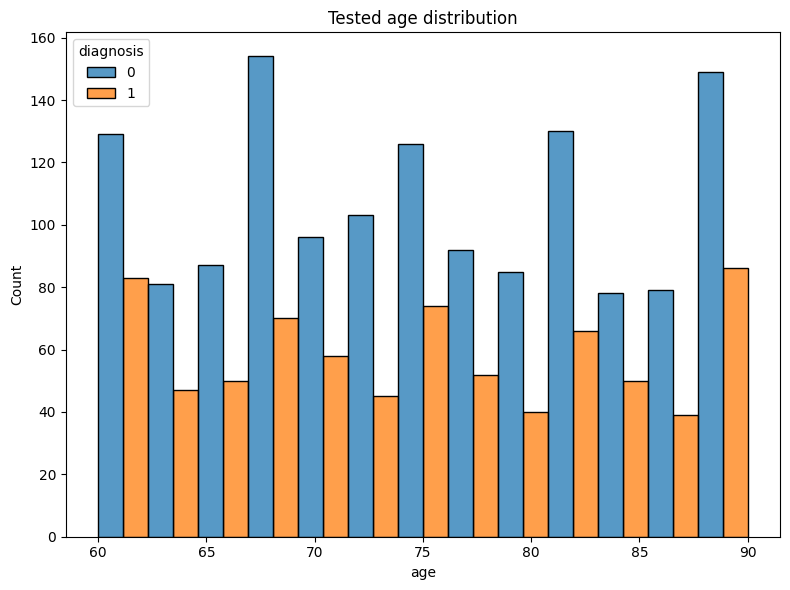

In [4]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Tested age distribution")
sns.histplot(data=df,x='age',color='#50727B',hue='diagnosis',multiple="dodge")

plt.tight_layout()
plt.show()

# Data Cleaning

In [5]:
ethnicity_dict={0:"Caucasian",1:"African American",2:"Asian",3:"Other"}
education_dict={0:"None",1:"High School",2:"Bachelor's",3:"Higher"}

df['ethnicity']=df['ethnicity'].apply(lambda x: ethnicity_dict[x])
df['educationlevel']=df['educationlevel'].apply(lambda x: education_dict[x])

df.drop(columns=["patientid","doctorincharge","cholesteroltotal","systolicbp","age","diastolicbp"],axis=1,inplace=True)

# PCA optionality

In [6]:
# definiation of numeric df columns
numeric_cols=df.select_dtypes("number").drop(columns=['diagnosis'])
# VIF dataframe 
vif=pd.DataFrame()
vif["feature"] = numeric_cols.columns 
  
# calculating VIF for each feature 
vif["VIF"] = [variance_inflation_factor(numeric_cols.values, i) 
                          for i in range(len(numeric_cols.columns))] 
  
print(f"VIF score under 5 is ok, over 10 means multicollinearity suspicious\n{vif.sort_values(by='VIF', ascending=False)}")

VIF score under 5 is ok, over 10 means multicollinearity suspicious
                      feature        VIF
6                sleepquality  13.806116
1                         bmi  12.763120
13             cholesterolldl   8.232232
14             cholesterolhdl   7.012664
15   cholesteroltriglycerides   5.705526
17       functionalassessment   3.978354
5                 dietquality   3.890771
3          alcoholconsumption   3.877876
4            physicalactivity   3.851107
16                       mmse   3.841532
20                        adl   3.748301
0                      gender   2.022688
25              forgetfulness   1.445744
2                     smoking   1.409367
7     familyhistoryalzheimers   1.343187
18           memorycomplaints   1.273269
21                  confusion   1.259844
10                 depression   1.256280
22             disorientation   1.201688
24  difficultycompletingtasks   1.200617
19         behavioralproblems   1.200493
9                    diabetes 

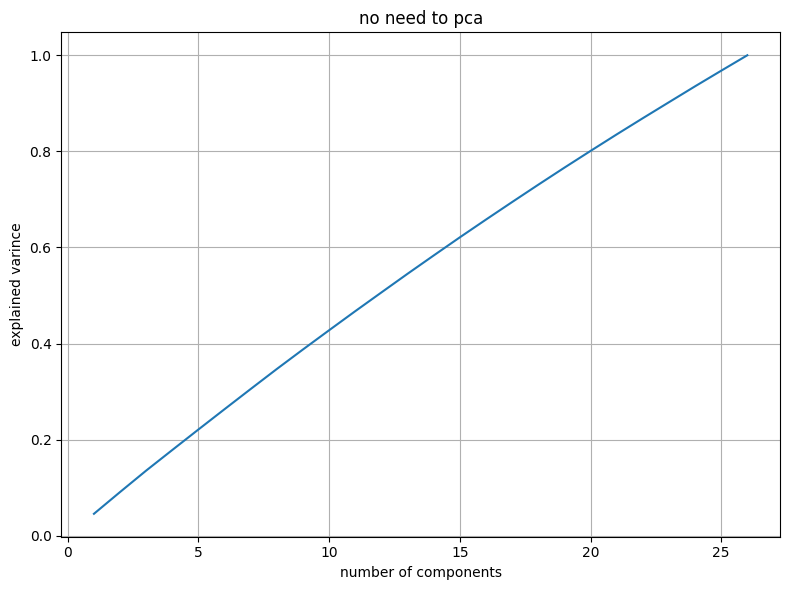

In [13]:
def pca_elbow_component_metric(df):
    scaler=StandardScaler()
    df_scaled=scaler.fit_transform(df)
    
    var_explained_ratio=[]
    for n in range(1,len(df.columns)+1):
        my_pca=PCA(n_components=n)
        my_pca.fit(df_scaled)

        var_explained_ratio.append(np.sum(my_pca.explained_variance_ratio_))
    
    return var_explained_ratio

var_explained_ratio_list=pca_elbow_component_metric(df.select_dtypes("number").drop(columns=['diagnosis']))

plt.figure(figsize=(8,6),dpi=100)
plt.plot(range(1,len(var_explained_ratio_list) + 1),var_explained_ratio_list)
plt.title("no need to pca")
plt.xlabel("number of components")
plt.ylabel("explained varince")
plt.grid(True)
plt.tight_layout()
plt.show()

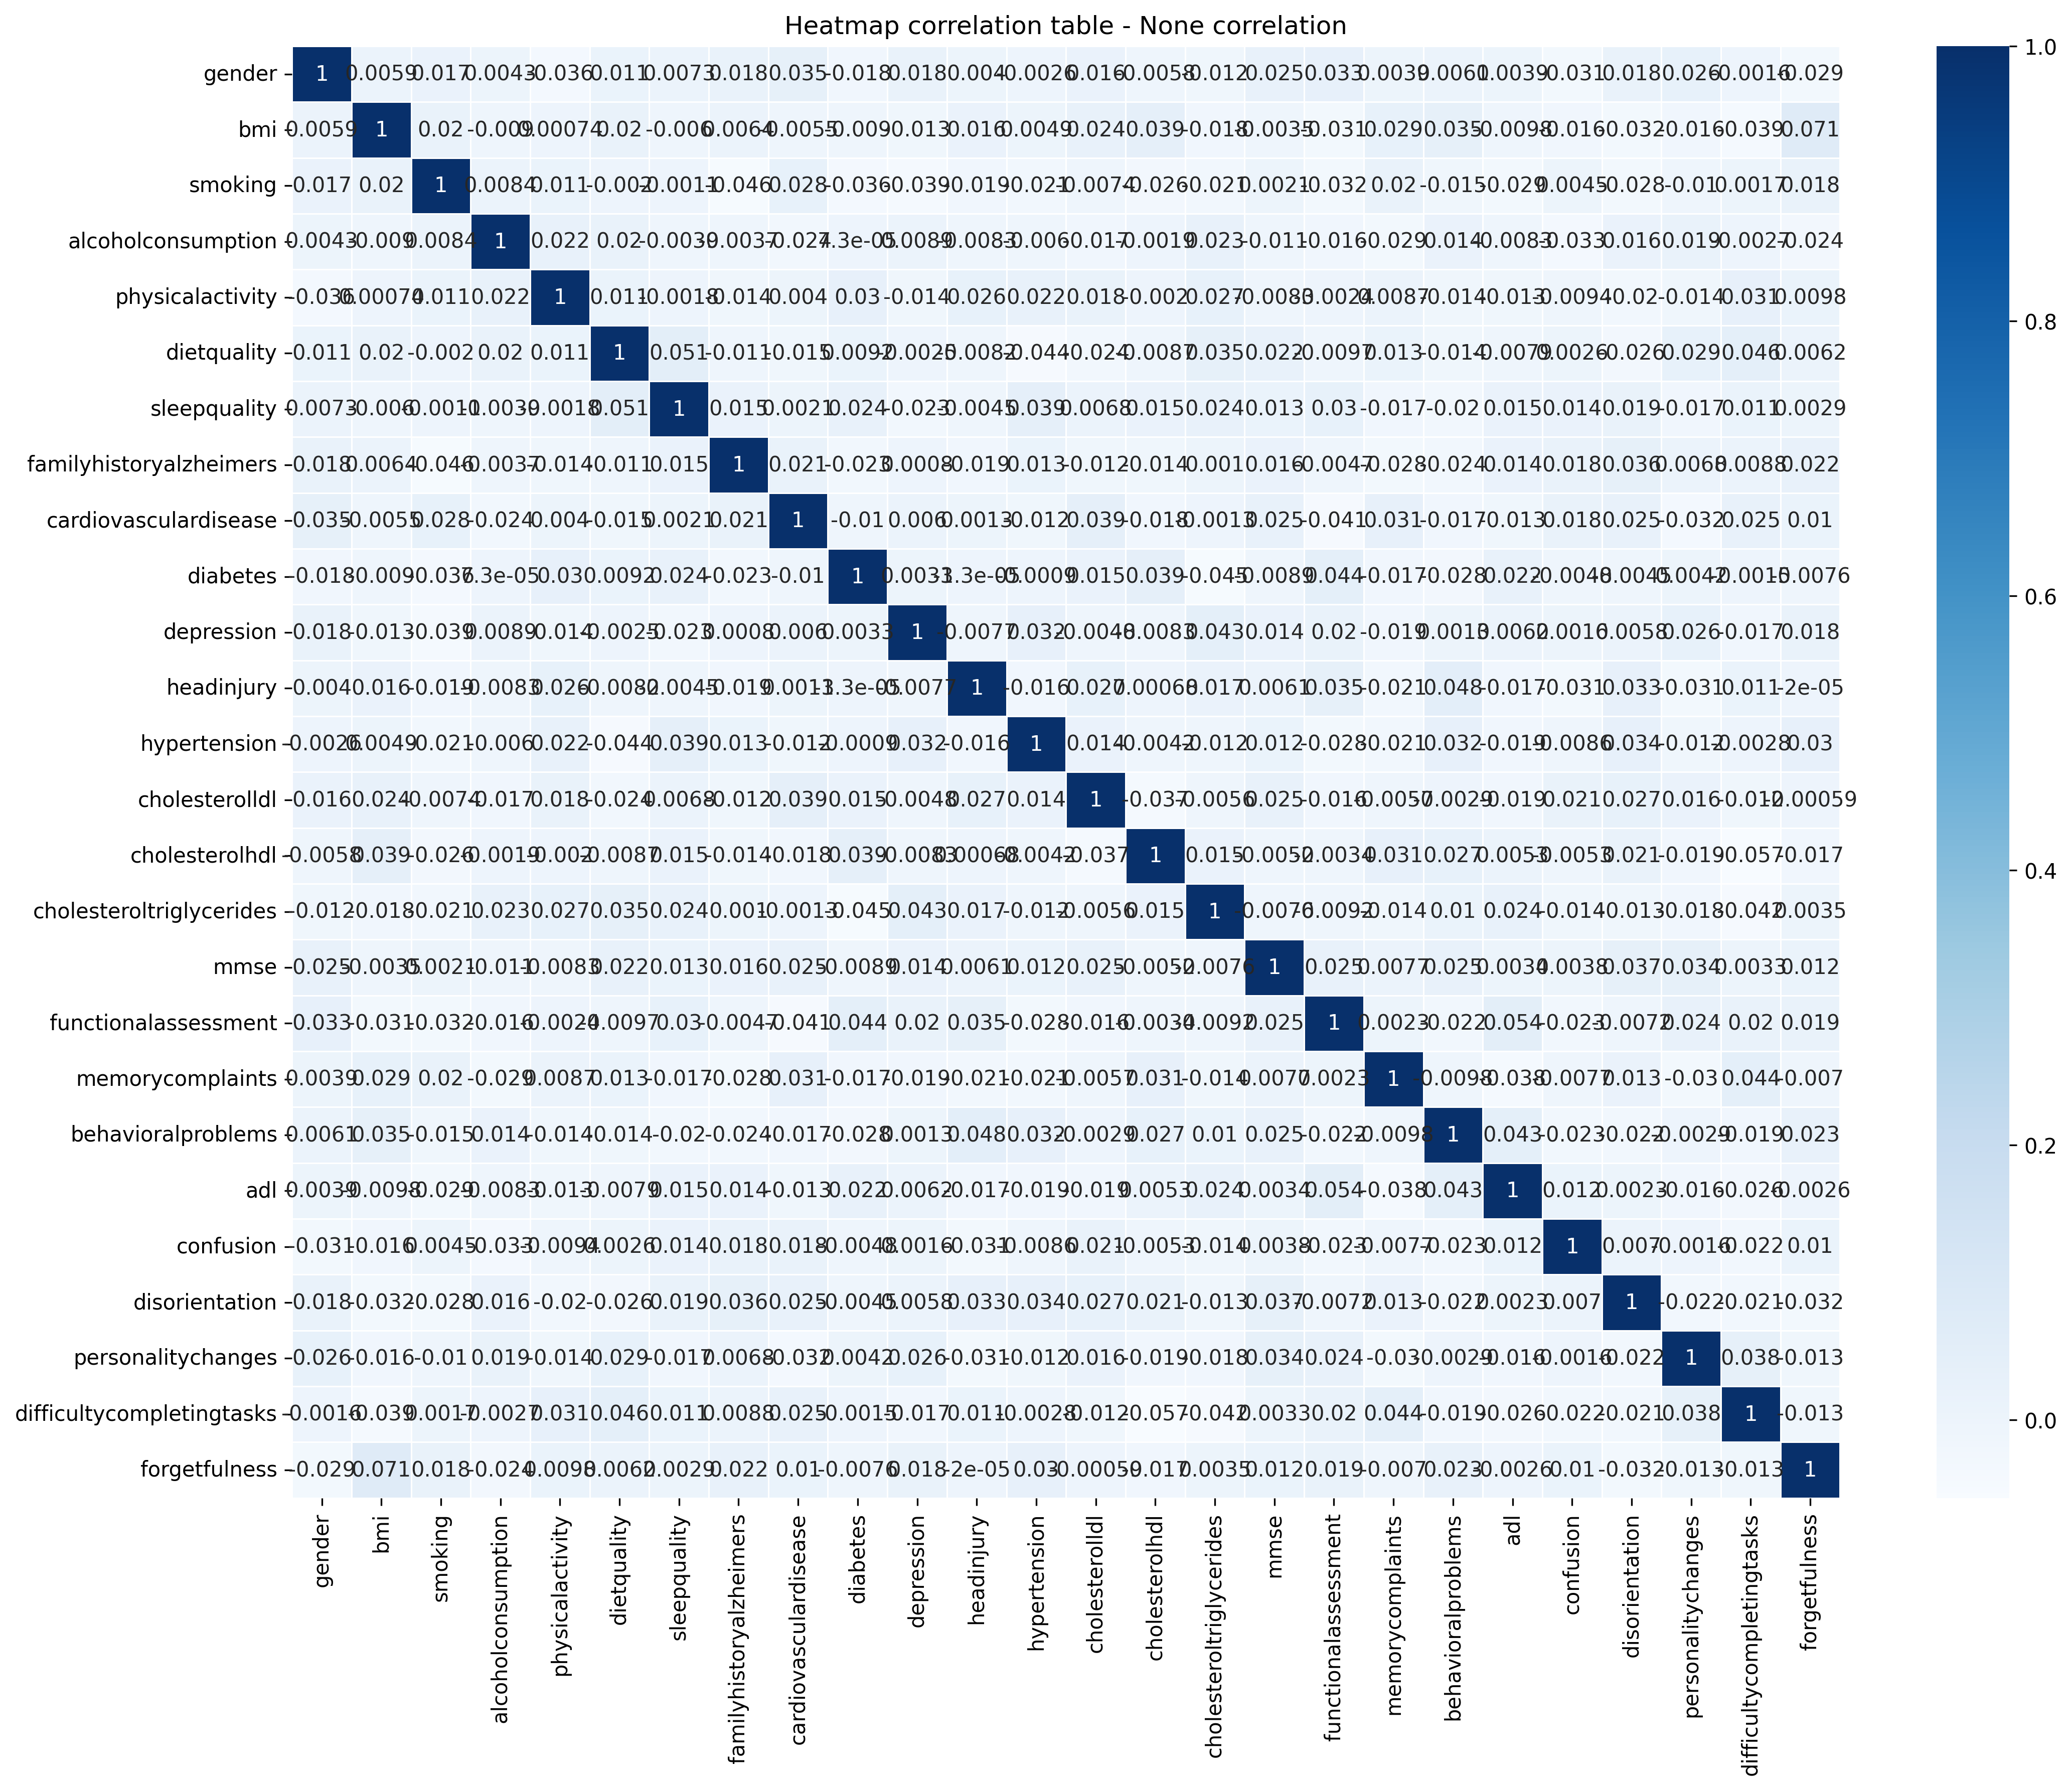

In [18]:
plt.figure(figsize=(15,12),dpi=300)
plt.title("Heatmap correlation table - None correlation")
sns.heatmap(data=df.select_dtypes("number").drop(columns=['diagnosis']).corr(),cmap='Blues', linewidths=0.7,annot=True)

plt.tight_layout()
plt.show()

# EDA

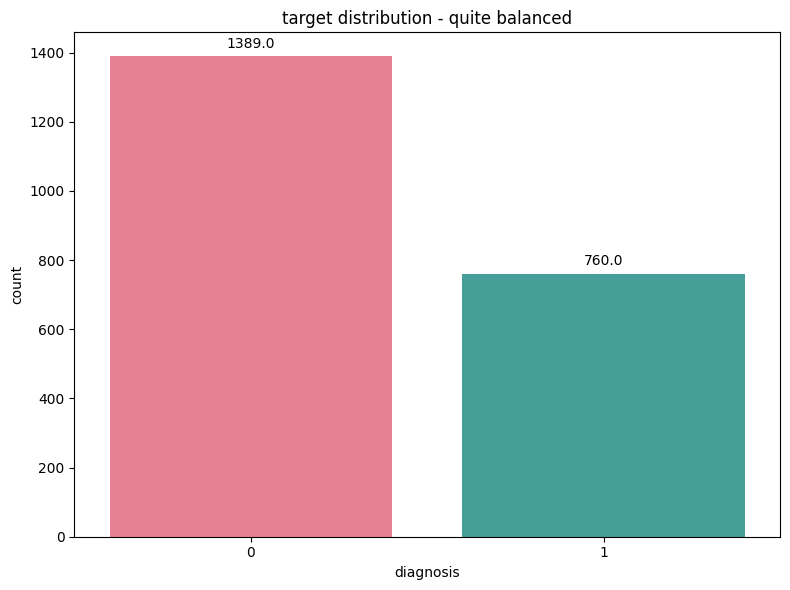

In [44]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("target distribution - quite balanced")
ax=sns.countplot(data=df,x='diagnosis',palette='husl')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.tight_layout()
plt.show()

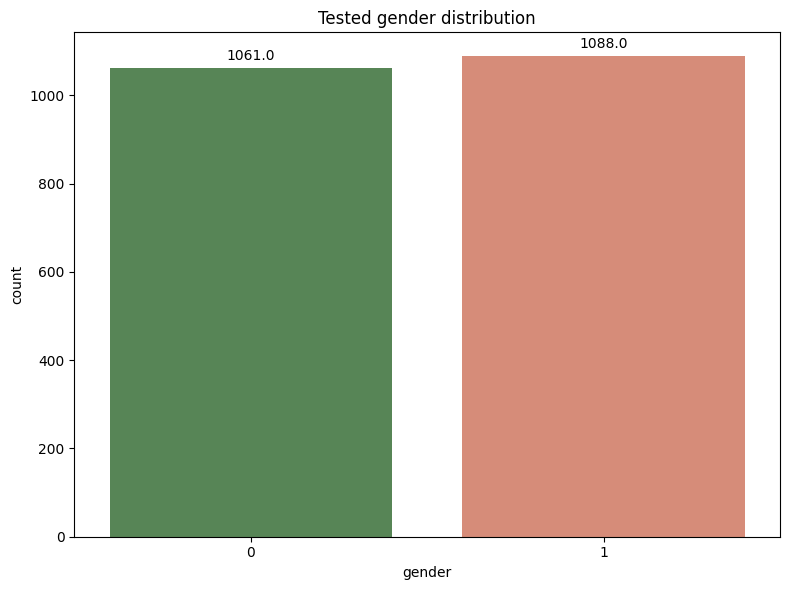

In [25]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Tested gender distribution")
ax=sns.countplot(data=df,x='gender',palette=['#508D4E','#E68369'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')
plt.tight_layout()
plt.show()

In [19]:
df.columns

Index(['gender', 'ethnicity', 'educationlevel', 'bmi', 'smoking',
       'alcoholconsumption', 'physicalactivity', 'dietquality', 'sleepquality',
       'familyhistoryalzheimers', 'cardiovasculardisease', 'diabetes',
       'depression', 'headinjury', 'hypertension', 'cholesterolldl',
       'cholesterolhdl', 'cholesteroltriglycerides', 'mmse',
       'functionalassessment', 'memorycomplaints', 'behavioralproblems', 'adl',
       'confusion', 'disorientation', 'personalitychanges',
       'difficultycompletingtasks', 'forgetfulness', 'diagnosis'],
      dtype='object')

# PreProccessing

In [22]:
X=df.drop(columns=["diagnosis"],axis=1)
y=df['diagnosis']

X_train,X_test,y_train,y_test=split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [24]:
class myOneHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        """constructor"""
        super().__init__()
        self.ohe=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
            
    def fit(self,X,y=None):
        """fit the non numric data on ohe object/bool"""
        self.ohe.fit(X.select_dtypes("object"))
        
        return self
    
    
    def transform(self,X):
        """transform the data we learned in the fit and combine it with the other data"""
        output=pd.DataFrame(self.ohe.transform(X.select_dtypes("object")))
        X_numeric=X.select_dtypes("number")
        return np.concatenate([output,X_numeric],axis=1)

In [45]:
X_train

,gender,ethnicity,educationlevel,bmi,smoking,alcoholconsumption,physicalactivity,dietquality,sleepquality,familyhistoryalzheimers,...,mmse,functionalassessment,memorycomplaints,behavioralproblems,adl,confusion,disorientation,personalitychanges,difficultycompletingtasks,forgetfulness
1433,1,Asian,High School,27.764232,1,16.543170,0.281379,5.923418,7.836104,0,...,25.399206,3.085543,0,0,6.643693,0,0,0,0,0
630,0,Caucasian,Higher,37.098744,0,1.360202,9.242990,1.819284,5.218052,1,...,8.292136,5.616830,0,1,3.884562,0,0,0,0,1
78,1,Other,Bachelor's,15.908275,0,16.329031,1.915913,6.607292,6.146166,0,...,21.042238,3.662461,0,0,4.013722,0,0,1,1,0
366,1,Caucasian,Bachelor's,30.302432,1,11.814030,6.281170,6.204349,6.825155,0,...,28.609438,4.648135,0,0,9.355700,1,0,1,0,1
1996,0,Caucasian,Bachelor's,24.565357,1,2.273373,9.976581,2.057188,4.715534,0,...,2.629135,9.601238,1,0,8.818932,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,Caucasian,Bachelor's,22.874070,0,16.006145,7.411056,2.341965,6.688947,1,...,7.325867,5.432951,0,0,0.214825,0,0,1,0,0
1095,0,African American,Higher,25.522233,0,15.432489,4.149322,9.605963,5.235691,0,...,11.671289,0.298203,1,0,5.590417,0,0,0,0,1
1130,0,African American,Bachelor's,29.216597,0,9.424858,8.004951,4.276642,7.641721,0,...,28.463207,1.957638,0,0,4.030134,0,0,0,0,0
1294,1,Caucasian,High School,25.741021,0,0.036260,6.292084,9.072249,8.497493,0,...,6.230189,5.535547,0,0,3.464861,0,0,0,0,0


In [25]:
my_pipe=Pipeline(steps=
                 [("ohe",myOneHotEncoder()),
                  ("scaler",StandardScaler())])

X_train_model=my_pipe.fit_transform(X_train)
X_test_model=my_pipe.transform(X_test)

# Model

In [62]:
lr=LogisticRegression(random_state=42)

penalty_list=['l2']
c=np.linspace(0,1,50)

params_set={'C':c,'penalty':penalty_list}

model=GridSearchCV(lr,params_set,cv=5,scoring='roc_auc')

In [63]:
model.fit(X_train_model,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
                         'penalty': ['l2']},
             scoring='roc_auc')

In [74]:
y_pred=model.predict(X_test_model)
y_pred_proba=model.predict_proba(X_test_model)[:,1]

print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88       277
           1       0.81      0.69      0.75       153

    accuracy                           0.83       430
   macro avg       0.83      0.80      0.81       430
weighted avg       0.83      0.83      0.83       430



In [65]:
model.best_params_

{'C': np.float64(0.02040816326530612), 'penalty': 'l2'}

In [78]:
fpr, tpr, thresholds=roc_curve(y_true=y_test,y_score=y_pred_proba)

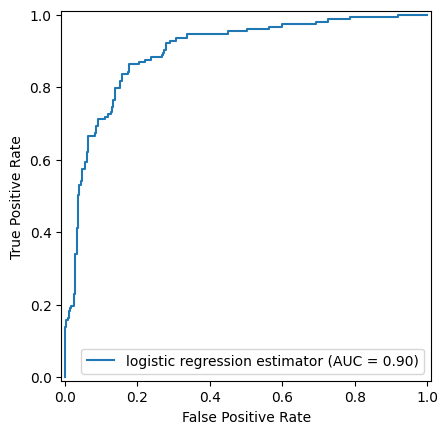

In [84]:
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='logistic regression estimator')
display.plot()  
plt.show()  